In [1]:
import numpy as np
import os
import shutil
import json
import matplotlib.pyplot as plt
import tempfile
import joblib
import sklearn
import copy
from sklearn.preprocessing import LabelEncoder
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import ray
from ray.tune.schedulers import ASHAScheduler
from ray import tune
from ray.train import Checkpoint
from ray import train

from deep_entropy_scaling.nn_dataset import dataset, minmax_to_json, minmax_from_json
from deep_entropy_scaling.nn_training import train_looper, load_model0, best_model  # train_loop

ray.shutdown()
ray.init()

class species_dataset(Dataset):
    """
    - standard dataset for final training
    - returns random batches
    """
    # Constructor with defult values
    def __init__(self, data_csv, log_transform=True,
                 x_features=["temperature", "resd_entropy", "molarweight",
                             "m", "sigma", "epsilon_k", "kappa_ab",
                             "epsilon_k_ab", "mu"],
                 y_features=["log_value"],
                 keep_features=["iupac_name", "cas", "family"],
                 ScalerX=sklearn.preprocessing.MinMaxScaler(),
                 ScalerY=sklearn.preprocessing.MinMaxScaler(),
                 scaler_fit=False, scalerX=None, scalerY=None,
                 keepXY=False, sample_species=True,
                 ):
        self.x_features = x_features
        self.y_features = y_features
        self.keep_features = keep_features
        self.sample_species = sample_species
        self.data_csv = data_csv
        data = pd.read_csv(data_csv)
        # print("data.keys",data.keys())
        data["resd_entropy"] = np.abs(data["resd_entropy"])
        # print(data.shape)
        if log_transform:
            data = data[data["pressure"] > 0]
            data["log_pressure"] = np.log(data["pressure"])
            data["log_value"] = np.log(data["value"])
        # print(data.shape)

        X = np.array(data[x_features])
        Y = np.array(data[y_features])
        if keepXY:
            self.X = X
            self.Y = Y
        self.keep = data[keep_features]
        self.encoded_species = LabelEncoder().fit_transform(data["cas"])
        self.encoded_families = LabelEncoder().fit_transform(data["family"])
        del data

        self.n_species = np.unique(self.encoded_species).shape[0]
        self.n_families = np.unique(self.encoded_families).shape[0]

        # norm data here
        if scaler_fit:
            self.ScalerX = ScalerX
            self.ScalerY = ScalerY
            self.scalerX = self.ScalerX.fit(X)
            self.scalerY = self.ScalerY.fit(Y)
        else:
            self.ScalerX = "external"
            self.ScalerY = "external"
            self.scalerX = scalerX
            self.scalerY = scalerY

        self.X_scaled = torch.Tensor(self.scalerX.transform(X))
        self.Y_scaled = torch.Tensor(self.scalerY.transform(Y))

        self.len = self.Y_scaled.shape[0]

        self.species_indexes = []
        for n in np.unique(self.encoded_species):
            p = np.where(self.encoded_species == n)
            self.species_indexes.append(np.squeeze(p))    

        self.families_indexes = []
        for n in np.unique(self.encoded_families):
            p = np.where(self.encoded_families == n)
            self.families_indexes.append(np.squeeze(p))            
        return

    # Getter
    def __getitem__(self, index):
        if self.sample_species:
            p = self.species_indexes[index]
            print( p.shape )
            a = torch.squeeze(self.X_scaled[p].float())
            b = torch.squeeze(self.Y_scaled[p].float())
            sample = a,b
            print( sample[0].size(), sample[1].size() )
        else:
            sample = self.X_scaled[index].float(), self.Y_scaled[index].float()
        return sample

    # Get Length
    def __len__(self):
        if self.sample_species:
            return self.n_species
        else:
            return self.len

    def get_keep(self, index):
        return self.keep.iloc[index]

    def get_data(self):
        return self.X_scaled.float(), self.Y_scaled.float()

    # Getter
    def get_species(self, index):
        # print( index )
        p = self.species_indexes[index]
        # print( p.shape )
        a = torch.squeeze(self.X_scaled[p].float())
        b = torch.squeeze(self.Y_scaled[p].float())
        sample = a,b
        # print( sample[0].size(), sample[1].size() )
        return sample

    def get_species_keep(self, index):
        return self.keep.iloc[self.species_indexes[index]]

def species_train_loop(config_train, config, epochs=100, freeze=[],
               n_restart=1, patience=20, report_result=True):

    # data_train = config["data_train"]
    # data_val = config["data_val"]

    y_features = ["log_value"]
    # scalerX = joblib.load(config["model_path"]+'Xscaler.gz')
    # scalerY = joblib.load(config["model_path"]+'Yscaler.gz')
    scalerX = minmax_from_json(config["model_path"]+'Xscaler.json')
    scalerY = minmax_from_json(config["model_path"]+'Yscaler.json')
    data_train = species_dataset(config["data_csv_train"], y_features=y_features,
                         scalerX=scalerX, scalerY=scalerY)
    data_val = species_dataset(config["data_csv_val"], y_features=y_features,
                       scalerX=scalerX, scalerY=scalerY)
    # config["data_train"] = data_train
    # config["data_val"] = data_val

    dataloader = DataLoader(data_train, 1,
                            shuffle=True, pin_memory=False)
    # Initialize Variables for EarlyStopping
    best_loss = float('inf')
    best_loss = 1e6
    best_l1 = 1e6
    best_val_loss = 1e6
    best_val_l1 = 1e6
    i_re_best = 0

    model = load_model0({**config_train, **config,
                        "n_entropy_features": config_train["n_features"]})
    # ini weights
    best_model_weights = copy.deepcopy(model.state_dict())

    # re_losses = []
    # re_l1s = []
    # re_val_losses = []
    # re_val_l1s = []
    n_patience = patience

    for i_re in np.arange(n_restart):

        model = load_model0({**config_train, **config,
                             "n_entropy_features": config_train["n_features"]})

        # device = "cpu"
        # if torch.cuda.is_available():
        #     device = "cuda:0"
        #     if torch.cuda.device_count() > 1:
        #         model = nn.DataParallel(model)
        # model.to(device)

        loss_fn = nn.MSELoss()
        mead_fn = nn.L1Loss()
        # optimizer = optim.SGD(model.parameters(), lr=0.001,
        # momentum=0.9, weight_decay=1e-7)
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=config_train["lr"], weight_decay=1e-7)

        # losses = []
        # l1s = []
        # val_losses = []
        # val_l1s = []

        for epoch in range(epochs):  # loop over the dataset multiple times
            # print(epoch)
            for X_train_scaled, y_train_scaled in dataloader:
                X_train_scaled = torch.squeeze(X_train_scaled)
                y_train_scaled = torch.squeeze(y_train_scaled)

                log_vis = y_train_scaled#[:, 0]
                resd_entropy = X_train_scaled[:, 1].detach().numpy()

                print("X_train_scaled",X_train_scaled.shape)
                y_pred0 = torch.squeeze(model.forward_ref(X_train_scaled))
                # print( y_pred0.shape, log_vis.shape )

                log_vis_star = log_vis - y_pred0
                log_vis_star = torch.squeeze(log_vis_star)
                # print( log_vis_star.shape, resd_entropy.shape )

                deg = int(config["poly_deg"])
                z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
                yy = np.poly1d(z)(resd_entropy)
                y_pred = torch.Tensor(yy)

                print( "y_pred", y_pred.shape, log_vis_star.shape  )
                loss = loss_fn(y_pred, log_vis_star)

                # Zero the gradients before running the backward pass.
                model.zero_grad()

                # Backward pass: compute gradient of the loss with respect
                # to all the learnable parameters of the model.
                # Internally, the parameters of each Module are stored
                # in Tensors with requires_grad=True, so this call will
                # compute gradients for all learnable parameters in the model.
                loss.backward()

                # Update the weights using gradient descent.
                # Each parameter is a Tensor, so we can access
                # its gradients like we did before.
                # with torch.no_grad():
                #    for param in model.parameters():
                #        param -= learning_rate * param.grad
                optimizer.step()

                #print("y_pred.shape, y_train_scaled.shape")
                #print(y_pred.shape, y_train_scaled.shape)

            loss = 0
            l1 = 0        
            for ii in range(data_val.n_species):
                X, Y = data_val.get_species(ii)
                if len(Y.shape) > 1:
                    # print(Y.shape)
                    log_vis = Y[:, 0]
                    resd_entropy = X[:, 1].detach().numpy()
    
                    y_pred0 = torch.squeeze(model.forward_ref(X))
                    # print( y_pred0.shape, log_vis.shape )
    
                    log_vis_star = log_vis - y_pred0
                    log_vis_star = torch.squeeze(log_vis_star)
                    # print( log_vis_star.shape, resd_entropy.shape )
    
                    deg = int(config["n_features"])
                    z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
                    yy = np.poly1d(z)(resd_entropy)
                    y_pred = torch.Tensor(yy)
                    loss += loss_fn( y_pred , log_vis_star )
                    l1   += mead_fn( y_pred , log_vis_star )
        
            val_loss = loss
            val_l1 = l1

            # losses.append(loss)
            # l1s.append(l1)
            # val_losses.append(val_loss)
            # val_l1s.append(val_l1)

            # Early stopping
            if val_loss < best_val_loss:
                best_loss = loss
                best_l1 = l1
                best_val_loss = val_loss
                best_val_l1 = val_l1
                best_model_weights = copy.deepcopy(model.state_dict())
                n_patience = patience  # Reset patience counter
                i_re_best = i_re

            elif epoch >= patience:
                n_patience -= 1
                if n_patience == 0:
                    print("early termination")
                    break
            # print("")
            # gc.collect()

        # re_losses.append(losses)
        # re_l1s.append(l1s)
        # re_val_losses.append(val_losses)
        # re_val_l1s.append(val_l1s)
        print("fin RE")

    model.load_state_dict(best_model_weights)
    # if report_result:
    checkpoint_name = "checkpoint.pt"
    train_report = {"val_loss": float(best_val_loss),
                    "val_l1": float(best_val_l1),
                    "train_loss": float(best_loss), "train_l1": float(best_l1),
                    "epoch": epoch, "i_re_best": i_re_best}
    if report_result:
        with tempfile.TemporaryDirectory() as tcd:
            path = os.path.join(tcd, checkpoint_name)
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(tcd)

            train.report(
                train_report,
                checkpoint=checkpoint,
            )
        print("Finished Training", epoch)
        return model
    else:
        print("Finished Training", epoch)
        return model, train_report


def species_train_looper(config_train, config):

    config["checkpoint_path"] = ""

    # train all
    freeze = []
    species_train_loop(config_train, config, epochs=200,
               patience=40, n_restart=1, freeze=freeze,
               report_result=True)
    return

def species_main(config, config_train_space):

    y_features = ["log_value"]
    data_train = species_dataset(config["data_csv_train"], y_features=y_features,
                         scaler_fit=True)
    joblib.dump(data_train.scalerX, config["model_path"]+'Xscaler.gz')
    joblib.dump(data_train.scalerY, config["model_path"]+'Yscaler.gz')
    minmax_to_json(data_train.scalerX, config["model_path"]+'Xscaler.json')
    minmax_to_json(data_train.scalerY, config["model_path"]+'Yscaler.json')    
    del data_train


    config_train_space = {
        "lr": tune.choice(config_train_space["lr"]),
        "batch_size": tune.choice(config_train_space["batch_size"]),
        "n_layers_ref": tune.choice(config_train_space["n_layers_ref"]),
        "n_nodes_ref": tune.choice(config_train_space["n_nodes_ref"]),
        "n_nodes_feature_ref":
        tune.choice(config_train_space["n_nodes_feature_ref"]),
        "n_features_ref": tune.choice(config_train_space["n_features_ref"]),
        "n_features": tune.choice(config_train_space["n_features"]),
        "n_layers_parameter":
        tune.choice(config_train_space["n_layers_parameter"]),
        "n_nodes_parameter":
        tune.choice(config_train_space["n_nodes_parameter"]),
        "n_nodes_entropy_feature":
        tune.choice(config_train_space["n_nodes_entropy_feature"]),
        }

    #def train_lambda(x): return train_looper(x, config)

    scheduler = ASHAScheduler(
        max_t=1000,
        grace_period=200,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(species_train_looper, config=config),
            resources={"cpu": 6}
        ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            scheduler=scheduler,
            num_samples=1,
        ),
        param_space=config_train_space,
    )
    results = tuner.fit()
    best_result = results.get_best_result("val_l1", "min", scope="all")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["val_loss"]))
    print("Best trial final validation MEAD: {}".format(
        best_result.metrics["val_l1"]))

    return best_result, config


# ref training:
config_train_space = {
    "lr": [0.002, 0.001, 0.005],
    "batch_size": [64, 128, 256],

    "n_layers_ref": [4, 6, 8],
    "n_nodes_ref": [24, 36, 48],
    "n_nodes_feature_ref": [12, 16],
    
    "n_features_ref": [8, 12],
    "n_features": [8, 12],

    "n_layers_parameter": [4, 6, 8],
    "n_nodes_parameter": [36, 48, 64],
    "n_nodes_entropy_feature": [12, 16, 24],
}

"""
THE DATA IS NOT PUBLISHED.
THEREFORE YOU WONT BE ABLE TO RUN THIS NOTEBOOK WITHOUT ERRORS

USE YOUR OWN DATA TO TRAIN!

"""

config = {}
dpath = "/home/derwer/Desktop/PHD/deep_entropy_2/data_preparation/merged_data/"
config["data_csv_train"] = dpath + "vis_test_alk_deduped.csv"
config["data_csv_val"] = dpath + "vis_test_alk_deduped.csv"
config["data_csv_test"] = dpath + "vis_test_alk_deduped.csv"
config["poly_deg"] = 4

config["embedding_size"] = 7
config["build"] = "model0_ci"
config["build"] = "model0_ci_poly2"
config["build"] = "model0_ci_poly2_eta"
config["build"] = "model0_ci_norm2"
#config["build"] = "model0_ci_norm"
#config["build"] = "model0_ci_enorm"
#config["build"] = "model0_ci_p2n2"
#config["build"] = "model0_ci_n2"

new_train_run = False
config["model_path"] = "/home/derwer/Desktop/PHD/deep_entropy_2/models/denoise0/"

"""
UNCOMMENT IF YOU WANNA TRAIN IT YOURSELF :)
"""
if new_train_run:
    best_result, config = species_main(config, config_train_space)


2025-02-07 10:52:54,860	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [2]:
def species_best_model(config, exp_error=True):

    config["checkpoint_path_native"] = config["checkpoint_path"]
    cpath = os.path.join(config["model_path"], "checkpoint.pt")
    config["checkpoint_path"] = cpath
    try:
        shutil.copyfile(config["checkpoint_path_native"], cpath)
    except shutil.SameFileError:
        print("checkpoint copy failed (probably already the same file.)")

    data_csv_train = config["data_csv_train"]
    data_csv_val = config["data_csv_val"]
    data_csv_test = config["data_csv_test"]

    y_features = ["log_value"]
    # scalerX = joblib.load(config["model_path"]+'Xscaler.gz')
    # scalerY = joblib.load(config["model_path"]+'Yscaler.gz')
    scalerX = minmax_from_json(config["model_path"]+'Xscaler.json')
    scalerY = minmax_from_json(config["model_path"]+'Yscaler.json')
    data_train = dataset(data_csv_train, y_features=y_features,
                         scalerX=scalerX, scalerY=scalerY)
    data_val = dataset(data_csv_val, y_features=y_features,
                       scalerX=scalerX, scalerY=scalerY)
    data_test = dataset(data_csv_test, y_features=y_features,
                        scalerX=scalerX, scalerY=scalerY)

    model = load_model0(config)

    a = ["training", "validation", "test"]
    b = [data_train, data_val, data_test]
    for dd, data in zip(a, b):
        for ii in range(data.n_species):
            X, Y = data.get_species(ii)
            if len(Y.shape) > 1:
                # print(Y.shape)
                log_vis = Y[:, 0]
                resd_entropy = X[:, 1].detach().numpy()
                x = scalerX.inverse_transform(X.detach().numpy())[:, 1]

                y_pred0 = torch.squeeze(model.forward_ref(X))
                # print( y_pred0.shape, log_vis.shape )

                log_vis_star = log_vis - y_pred0
                log_vis_star = torch.squeeze(log_vis_star)
                # print( log_vis_star.shape, resd_entropy.shape )

                deg = int(config["n_features"])
                z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
                yy = np.poly1d(z)(resd_entropy)
                y_pred = torch.Tensor(yy)
                yy_pred = y_pred + y_pred0
                yy_pred = torch.unsqueeze(yy_pred,1)
                yy_pred = scalerY.inverse_transform(yy_pred.detach().numpy())
                llog_vis = torch.unsqueeze(log_vis,1)
                llog_vis = scalerY.inverse_transform(llog_vis.detach().numpy())
          
                if ii == 0:
                    plt.plot(x, log_vis_star.detach().numpy(), "kx",
                             label="experimental")
                else:
                    plt.plot(x, log_vis_star.detach().numpy(), "kx")

                if exp_error:
                    error = np.abs((np.exp(yy_pred) - np.exp(llog_vis)) / np.exp(llog_vis))
                    error = np.mean(error)
                else:
                    error = np.mean(np.abs((yy_pred - llog_vis) / llog_vis))
                    
                info = data.get_species_keep(ii)
                name = info["iupac_name"].iloc[0]
                plt.plot(x, y_pred, ".",
                         label=str(name)+" "+str(round(error*100, 2))+"%")        
        plt.title(dd)
        plt.legend(bbox_to_anchor=(1, 1.1))
        plt.savefig(config["model_path"]+dd+"_noise.png", bbox_inches="tight")
        plt.savefig(config["model_path"]+dd+"_noise.pdf", bbox_inches="tight")
        plt.show()
        plt.close()


    #config = {**config, **{"loss": losses, "l1": l1s}}
    fname = os.path.join(config["model_path"], "best_result_config.json")
    with open(fname, "w") as outfile:
        json.dump(config, outfile, indent=4, sort_keys=False, default=str)

    return model, data_train

if new_train_run:
    # config["data_csv_test"] = dpath + "vis_entropy_test_deduped.csv"
    cname = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
    final_result = {**best_result.metrics, **best_result.config, **config,
                    "checkpoint_path": cname,
                    "n_entropy_features": best_result.config["n_features"]}
    model, data_train = species_best_model(final_result, exp_error=True)


load model0_ci_norm2: model0_ci_norm2
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 7 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 19 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
xxx torch.Size([350, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


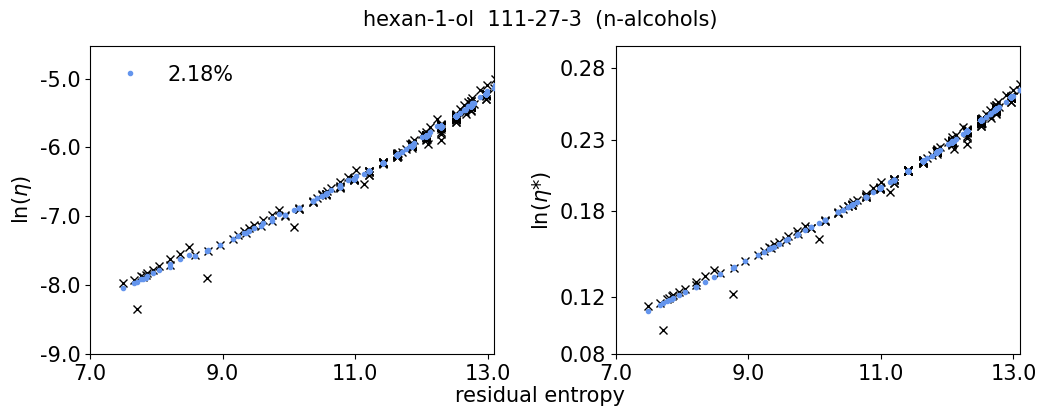

xxx torch.Size([346, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


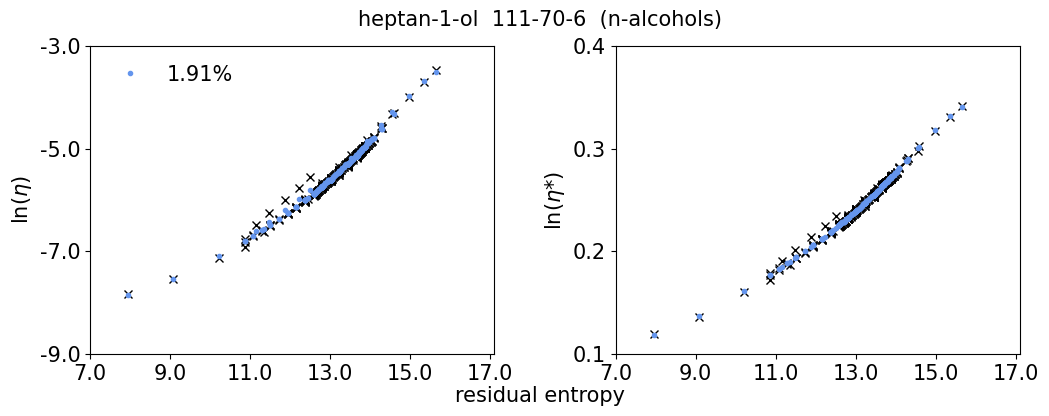

xxx torch.Size([487, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


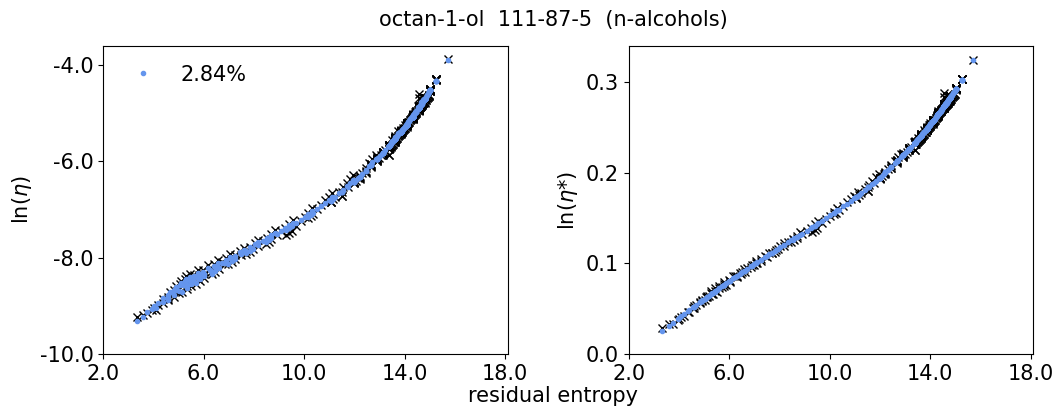

xxx torch.Size([392, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


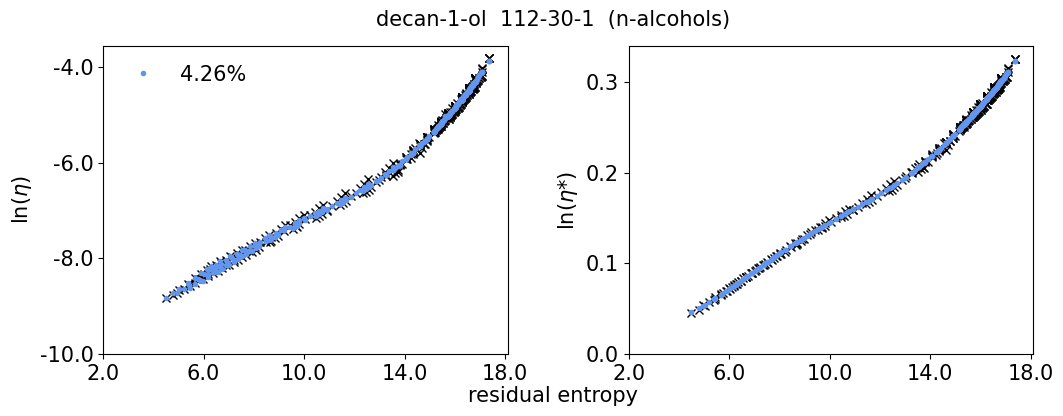

xxx torch.Size([239, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


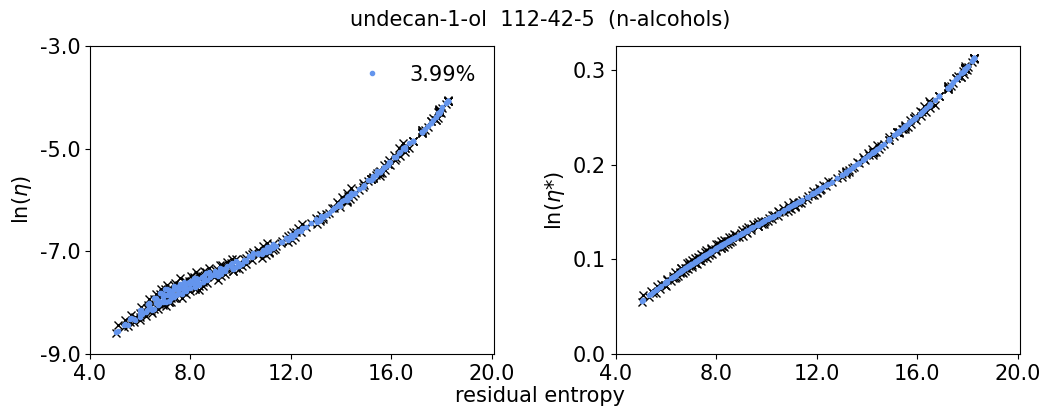

xxx torch.Size([280, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


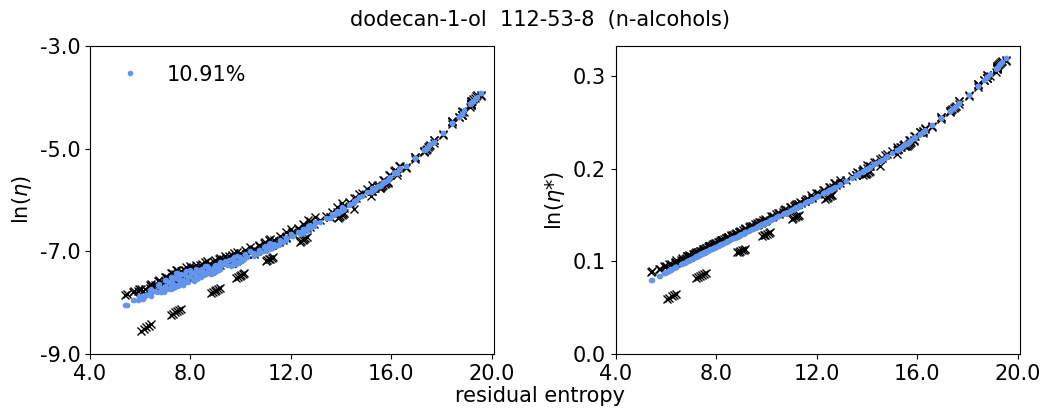

xxx torch.Size([13, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


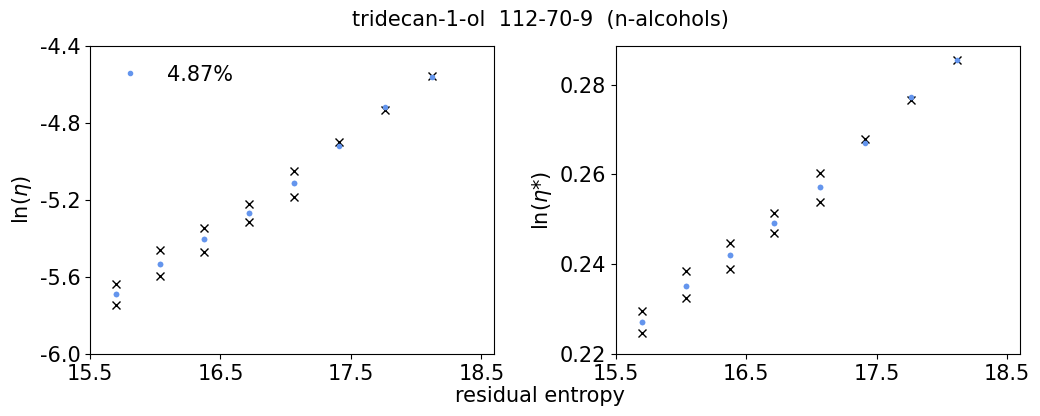

xxx torch.Size([26, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


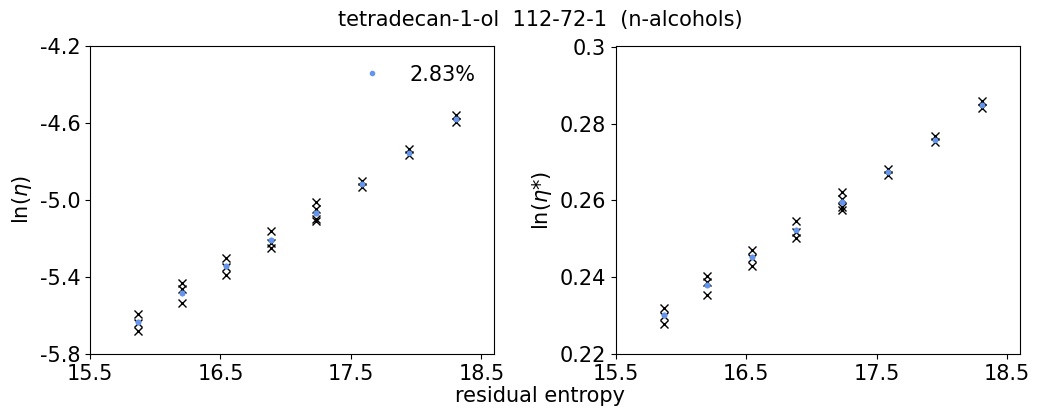

xxx torch.Size([42, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


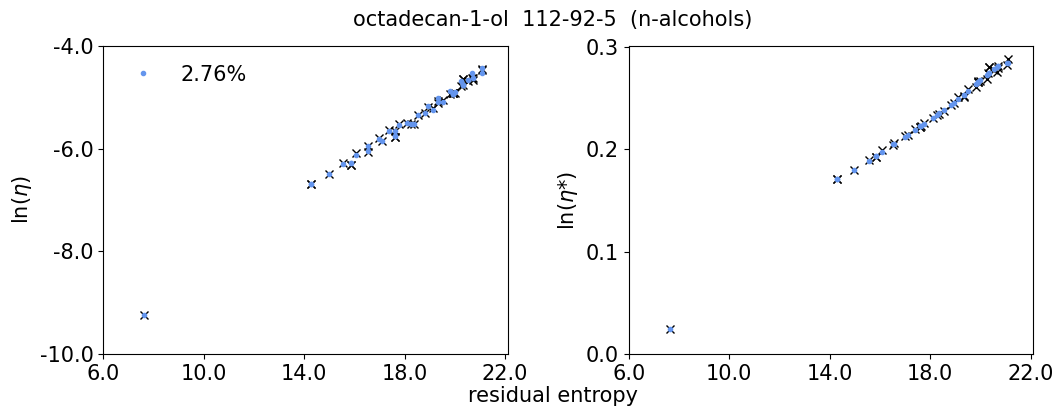

xxx torch.Size([336, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


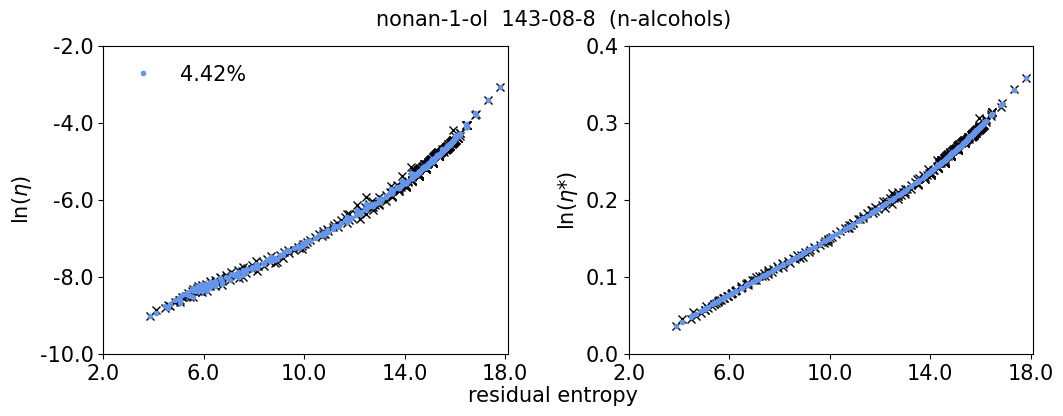

xxx torch.Size([90, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


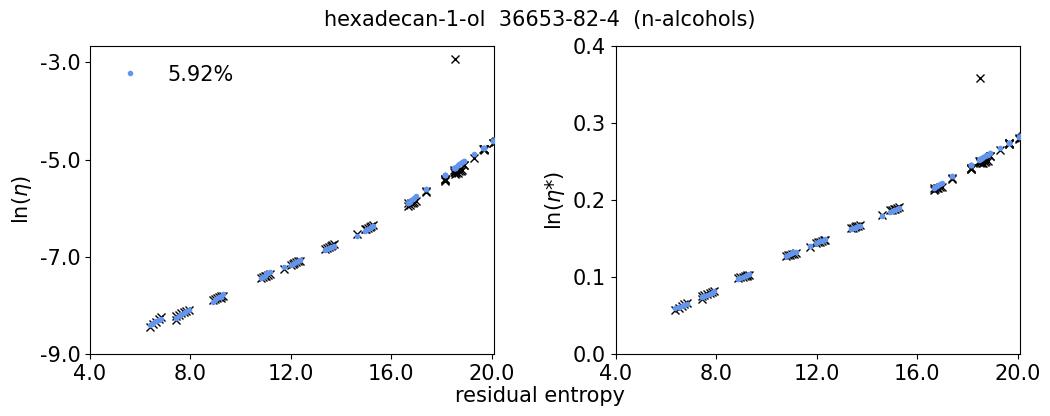

xxx torch.Size([1151, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


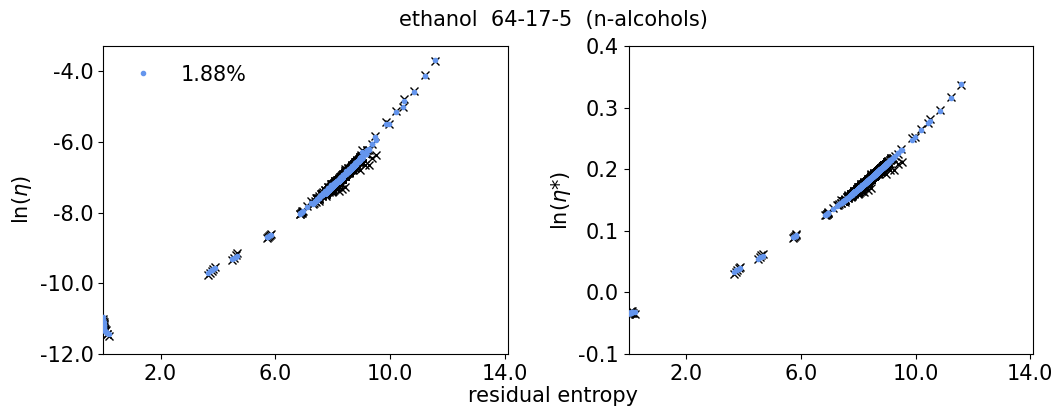

xxx torch.Size([994, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


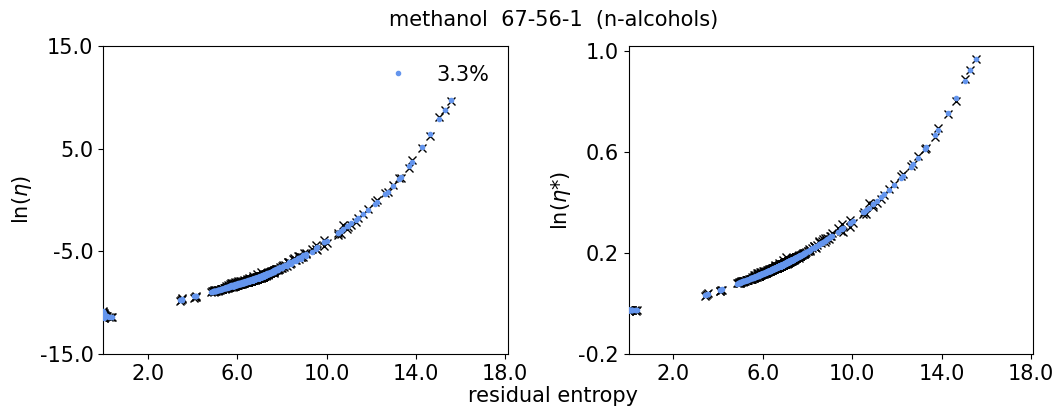

xxx torch.Size([1021, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


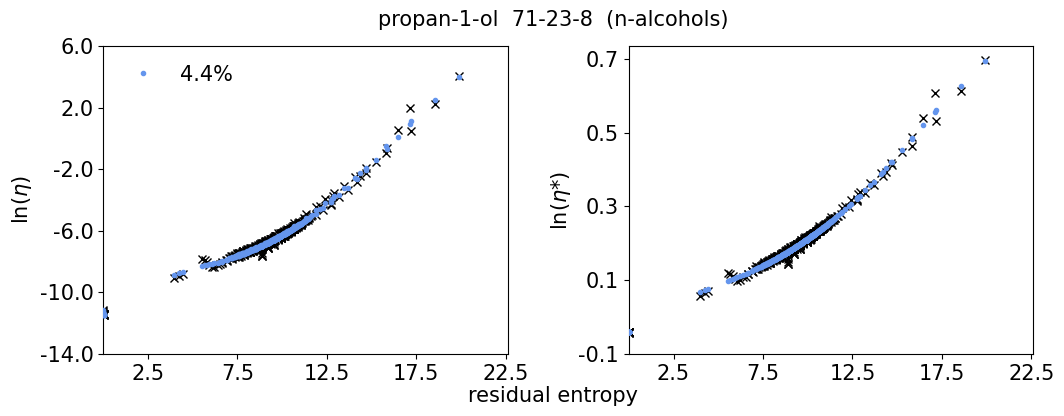

xxx torch.Size([1227, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


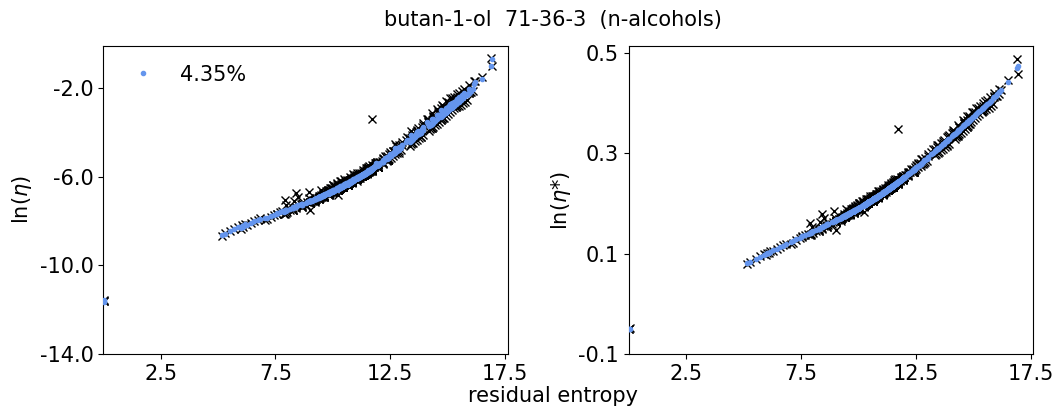

xxx torch.Size([508, 9])


/tmp/ipykernel_7302/3810325300.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


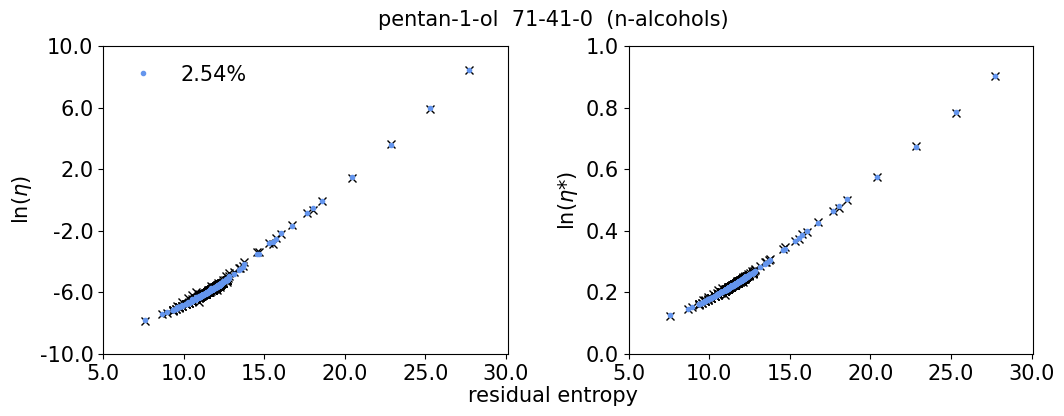

In [3]:
msize=8
fsize=15
alpha=0.3
lsize = 4

with open(config["model_path"]+"best_result_config.json") as f:
    config = json.load(f)

model = load_model0(config)
exp_error = True

data_csv_train = config["data_csv_train"]
data_csv_val = config["data_csv_val"]
data_csv_test = config["data_csv_test"]

y_features = ["log_value"]
# scalerX = joblib.load(config["model_path"]+'Xscaler.gz')
# scalerY = joblib.load(config["model_path"]+'Yscaler.gz')
scalerX = minmax_from_json(config["model_path"]+'Xscaler.json')
scalerY = minmax_from_json(config["model_path"]+'Yscaler.json')
data = dataset(data_csv_train, y_features=y_features,
                     scalerX=scalerX, scalerY=scalerY)

color = "cornflowerblue"

for ii in range(data.n_species):
    X, Y = data.get_species(ii)
    if len(Y.shape) > 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        
        fig.subplots_adjust(wspace=0.3, hspace=.01)
            
        # print(Y.shape)
        log_vis = Y[:, 0]
        resd_entropy = X[:, 1].detach().numpy()
        x = scalerX.inverse_transform(X.detach().numpy())[:, 1]

        y_pred0 = torch.squeeze(model.forward_ref(X))
        # print( y_pred0.shape, log_vis.shape )

        log_vis_star = log_vis - y_pred0
        log_vis_star = torch.squeeze(log_vis_star)
        # print( log_vis_star.shape, resd_entropy.shape )

        deg = int(config["n_features"])
        z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
        yy = np.poly1d(z)(resd_entropy)
        y_pred = torch.Tensor(yy)
        yy_pred = y_pred + y_pred0
        yy_pred = torch.unsqueeze(yy_pred,1)
        yy_pred = scalerY.inverse_transform(yy_pred.detach().numpy())
        llog_vis = torch.unsqueeze(log_vis,1)
        llog_vis = scalerY.inverse_transform(llog_vis.detach().numpy())

        if exp_error:
            error = np.abs((np.exp(yy_pred) - np.exp(llog_vis)) / np.exp(llog_vis))
            error = np.mean(error)
        else:
            error = np.mean(np.abs((yy_pred - llog_vis) / llog_vis))

        axs[1].plot( x, log_vis_star.detach().numpy(), "kx",zorder=0 )
        axs[1].plot( x, y_pred, ".",zorder=10, color=color )

        axs[0].plot( x, llog_vis, "kx",zorder=0 )
        axs[0].plot( x, yy_pred, ".",zorder=10, color=color, label=str(round(error*100,2))+"%") #, label=dd )
        
        sp = data.get_species_keep(ii).drop_duplicates().iloc[0]
        name = sp["iupac_name"]
      

        axs[0].set_ylabel(r"ln($\eta$)", fontsize=fsize)
        axs[1].set_ylabel(r"ln($\eta$*)", fontsize=fsize)

        txx = np.array(axs[0].get_xticks())
        txy = np.array(axs[0].get_yticks())
        tyy = np.array(axs[1].get_yticks())
        """
        rng = 3 -np.abs(txx[0]-txx[-1])
        if txx[0] < 0.5:
            txx[0]=0
        if rng > 0:
            txx = np.linspace( np.max([txx[0]-rng/2],0) , txx[-1]+rng/2, 7 )    
        else:
            txx = np.linspace( txx[0] , txx[-1], 7 )    
        
        rng = 3 -np.abs(txy[0]-txy[-1])
        if rng > 0:
            txy = np.linspace( txy[0]-rng/2 , txy[-1]+rng/2, 7 )       
        else:
            txy = np.linspace( txy[0] , txy[-1], 7 )          
        
        rng = 0.4 -np.abs(tyy[0]-tyy[-1])
        if rng > 0:
            tyy = np.linspace( tyy[0]-rng/2 , tyy[-1]+rng/2, 7 )     
        else:
            tyy = np.linspace( tyy[0] , tyy[-1], 7 )         
        txx = np.round(txx,1)
        txy = np.round(txy,1)
        tyy = np.round(tyy,2)
        """
        txx = np.round(txx[0::2],1)
        txy = np.round(txy[0::2],1)
        tyy = np.round(tyy[0::2],2)
        axs[0].set_xticks(txx,txx,fontsize=fsize)
        axs[1].set_xticks(txx,txx,fontsize=fsize)
        axs[0].set_yticks(txy,txy,fontsize=fsize)
        axs[1].set_yticks(tyy,tyy,fontsize=fsize)


    
        axs[1].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])
        axs[0].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])   
        
        handles, labels = axs[0].get_legend_handles_labels()
        axs[0].legend(handles[::-1], labels[::-1], frameon=False, fontsize=fsize)
        
        fig.text(0.5, -0.01, "residual entropy", fontsize=fsize, ha='center')     
        try:
            fig.text(0.5, 0.93, sp["iupac_name"]+"  "+sp["cas"]+"  ("+sp["family"]+")", fontsize=fsize, ha='center')     
        except:
            fig.text(0.5, 0.93, "unknown  "+sp["cas"]+"  ("+sp["family"]+")", fontsize=fsize, ha='center')         
            sp["iupac_name"] = "unknown"

        
        #plt.legend(bbox_to_anchor=(1, 1.1))
        plt.savefig(config["model_path"]+name+"_noise.png", bbox_inches="tight")
        plt.savefig(config["model_path"]+name+"_noise.pdf", bbox_inches="tight")
        plt.show()
        plt.close()

load model0_ci_norm2: model0_ci_norm2
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 7 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 19 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
xxx torch.Size([487, 9])
xxx torch.Size([1151, 9])
xxx torch.Size([1227, 9])


/tmp/ipykernel_7302/2470264070.py:56: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/2470264070.py:56: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/2470264070.py:56: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


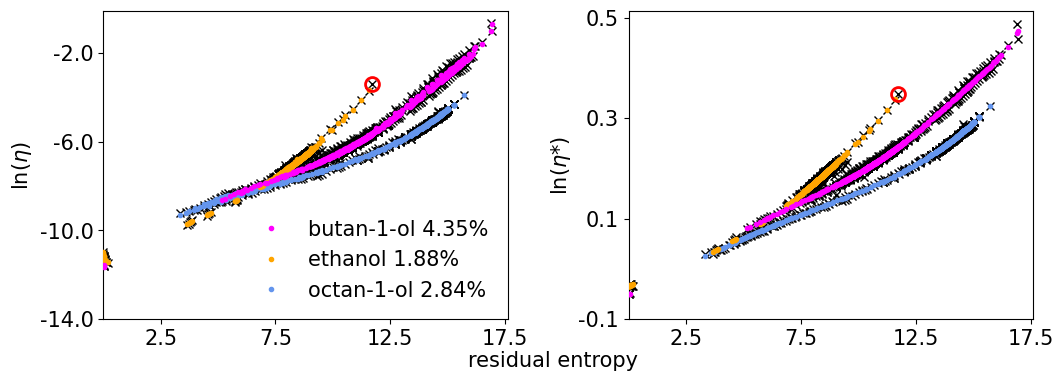

In [4]:
msize=8
fsize=15
alpha=0.3
lsize = 4

with open(config["model_path"]+"best_result_config.json") as f:
    config = json.load(f)

model = load_model0(config)
exp_error = True

data_csv_train = config["data_csv_train"]
data_csv_val = config["data_csv_val"]
data_csv_test = config["data_csv_test"]

y_features = ["log_value"]
# scalerX = joblib.load(config["model_path"]+'Xscaler.gz')
# scalerY = joblib.load(config["model_path"]+'Yscaler.gz')
scalerX = minmax_from_json(config["model_path"]+'Xscaler.json')
scalerY = minmax_from_json(config["model_path"]+'Yscaler.json')
data = dataset(data_csv_train, y_features=y_features,
                     scalerX=scalerX, scalerY=scalerY)

color = "cornflowerblue"

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.subplots_adjust(wspace=0.3, hspace=.01)

colors = ["cornflowerblue","orange","magenta","green"]

names = ["ethanol", "propan-1-ol", "butan-1-ol", "octan-1-ol"]
names = ["methanol","ethanol", "butan-1-ol", "octan-1-ol"]
names = ["ethanol", "butan-1-ol", "octan-1-ol"]

iii = 0
for ii in range(data.n_species):
    sp = data.get_species_keep(ii).drop_duplicates().iloc[0]
    name = sp["iupac_name"]    
    X, Y = data.get_species(ii)
    if len(Y.shape) > 1 and name in names:
            
        # print(Y.shape)
        log_vis = Y[:, 0]
        resd_entropy = X[:, 1].detach().numpy()
        x = scalerX.inverse_transform(X.detach().numpy())[:, 1]

        y_pred0 = torch.squeeze(model.forward_ref(X))
        # print( y_pred0.shape, log_vis.shape )

        log_vis_star = log_vis - y_pred0
        log_vis_star = torch.squeeze(log_vis_star)
        # print( log_vis_star.shape, resd_entropy.shape )

        deg = int(config["n_features"])
        z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
        yy = np.poly1d(z)(resd_entropy)
        y_pred = torch.Tensor(yy)
        yy_pred = y_pred + y_pred0
        yy_pred = torch.unsqueeze(yy_pred,1)
        yy_pred = scalerY.inverse_transform(yy_pred.detach().numpy())
        llog_vis = torch.unsqueeze(log_vis,1)
        llog_vis = scalerY.inverse_transform(llog_vis.detach().numpy())

        if exp_error:
            error = np.abs((np.exp(yy_pred) - np.exp(llog_vis)) / np.exp(llog_vis))
            error = np.mean(error)
        else:
            error = np.mean(np.abs((yy_pred - llog_vis) / llog_vis))
        
        axs[1].plot( x, log_vis_star.detach().numpy(), "kx",zorder=0 )
        axs[1].plot( x, y_pred, ".",zorder=10, color=colors[iii] )

        axs[0].plot( x, llog_vis, "kx",zorder=0 )
        axs[0].plot( x, yy_pred, ".",zorder=10, color=colors[iii], label=name+" "+str(round(error*100,2))+"%") #, label=dd )

        if name == "butan-1-ol":
            err = np.abs((yy_pred - llog_vis) / llog_vis)
            pp = np.squeeze(err) > 0.6
            axs[0].plot( x[pp], llog_vis[pp], "ro", fillstyle='none',zorder=1000, mew=2, ms=10 )
            axs[1].plot( x[pp], log_vis_star.detach().numpy()[pp], "ro", fillstyle='none',zorder=1000, mew=2, ms=10 )
            
        
        iii += 1


axs[0].set_ylabel(r"ln($\eta$)", fontsize=fsize)
axs[1].set_ylabel(r"ln($\eta$*)", fontsize=fsize)

txx = np.array(axs[0].get_xticks())
txy = np.array(axs[0].get_yticks())
tyy = np.array(axs[1].get_yticks())
"""
rng = 3 -np.abs(txx[0]-txx[-1])
if txx[0] < 0.5:
    txx[0]=0
if rng > 0:
    txx = np.linspace( np.max([txx[0]-rng/2],0) , txx[-1]+rng/2, 7 )    
else:
    txx = np.linspace( txx[0] , txx[-1], 7 )    

rng = 3 -np.abs(txy[0]-txy[-1])
if rng > 0:
    txy = np.linspace( txy[0]-rng/2 , txy[-1]+rng/2, 7 )       
else:
    txy = np.linspace( txy[0] , txy[-1], 7 )          

rng = 0.4 -np.abs(tyy[0]-tyy[-1])
if rng > 0:
    tyy = np.linspace( tyy[0]-rng/2 , tyy[-1]+rng/2, 7 )     
else:
    tyy = np.linspace( tyy[0] , tyy[-1], 7 )         
txx = np.round(txx,1)
txy = np.round(txy,1)
tyy = np.round(tyy,2)
"""
txx = np.round(txx[0::2],1)
txy = np.round(txy[0::2],1)
tyy = np.round(tyy[0::2],2)
axs[0].set_xticks(txx,txx,fontsize=fsize)
axs[1].set_xticks(txx,txx,fontsize=fsize)
axs[0].set_yticks(txy,txy,fontsize=fsize)
axs[1].set_yticks(tyy,tyy,fontsize=fsize)

axs[1].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])
axs[0].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])   

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1], frameon=False, fontsize=fsize)

fig.text(0.5, -0.01, "residual entropy", fontsize=fsize, ha='center')     

#plt.legend(bbox_to_anchor=(1, 1.1))
plt.savefig(config["model_path"]+"select_noise.png", bbox_inches="tight")
plt.savefig(config["model_path"]+"select_noise.pdf", bbox_inches="tight")
plt.show()
plt.close()

load model0_ci_norm2: model0_ci_norm2
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 7 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 19 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
xxx torch.Size([487, 9])


/tmp/ipykernel_7302/3810885440.py:54: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)


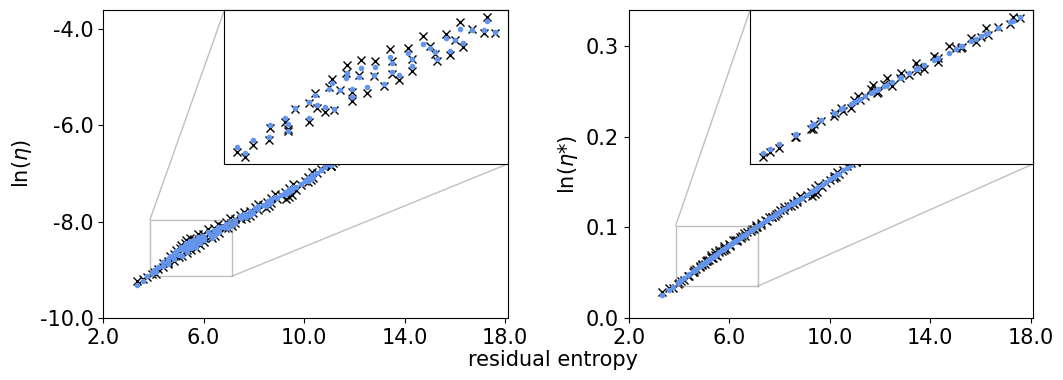

In [5]:
msize=8
fsize=15
alpha=0.3
lsize = 4

with open(config["model_path"]+"best_result_config.json") as f:
    config = json.load(f)

model = load_model0(config)
exp_error = True

data_csv_train = config["data_csv_train"]
data_csv_val = config["data_csv_val"]
data_csv_test = config["data_csv_test"]

y_features = ["log_value"]
# scalerX = joblib.load(config["model_path"]+'Xscaler.gz')
# scalerY = joblib.load(config["model_path"]+'Yscaler.gz')
scalerX = minmax_from_json(config["model_path"]+'Xscaler.json')
scalerY = minmax_from_json(config["model_path"]+'Yscaler.json')
data = dataset(data_csv_train, y_features=y_features,
                     scalerX=scalerX, scalerY=scalerY)

color = "cornflowerblue"

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.subplots_adjust(wspace=0.3, hspace=.01)

colors = ["cornflowerblue","orange","magenta","green"]

names = ["octan-1-ol"]

iii = 0
for ii in range(data.n_species):
    sp = data.get_species_keep(ii).drop_duplicates().iloc[0]
    name = sp["iupac_name"]    
    X, Y = data.get_species(ii)
    if len(Y.shape) > 1 and name in names:
            
        # print(Y.shape)
        log_vis = Y[:, 0]
        resd_entropy = X[:, 1].detach().numpy()
        x = scalerX.inverse_transform(X.detach().numpy())[:, 1]

        y_pred0 = torch.squeeze(model.forward_ref(X))
        # print( y_pred0.shape, log_vis.shape )

        log_vis_star = log_vis - y_pred0
        log_vis_star = torch.squeeze(log_vis_star)
        # print( log_vis_star.shape, resd_entropy.shape )

        deg = int(config["n_features"])
        z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
        yy = np.poly1d(z)(resd_entropy)
        y_pred = torch.Tensor(yy)
        yy_pred = y_pred + y_pred0
        yy_pred = torch.unsqueeze(yy_pred,1)
        yy_pred = scalerY.inverse_transform(yy_pred.detach().numpy())
        llog_vis = torch.unsqueeze(log_vis,1)
        llog_vis = scalerY.inverse_transform(llog_vis.detach().numpy())

        if exp_error:
            error = np.abs((np.exp(yy_pred) - np.exp(llog_vis)) / np.exp(llog_vis))
            error = np.mean(error)
        else:
            error = np.mean(np.abs((yy_pred - llog_vis) / llog_vis))
        
        axs[1].plot( x, log_vis_star.detach().numpy(), "kx",zorder=0 )
        axs[1].plot( x, y_pred, ".",zorder=1, color=colors[iii] )

        axs[0].plot( x, llog_vis, "kx",zorder=0 )
        axs[0].plot( x, yy_pred, ".",zorder=1, color=colors[iii], label=name+" "+str(round(error*100,2))+"%") #, label=dd )

        x1, x2, y1, y2 = 4, 7, -8, -9  # subregion of the original image
        p = (x>x1) & (x<x2)
        xx = x[ p ]

        yy_s = log_vis_star.detach().numpy()[p]
        yy = llog_vis[p]
        
        y_p = y_pred[p]
        yy_p = yy_pred[p]

        zm0 = axs[0].inset_axes([0.3,0.5,0.7,0.5])
        zm0.plot(xx,yy,"kx",zorder=0)
        zm0.plot(xx,yy_p,".",zorder=10, color=colors[iii])
        zm0.set_xticks([])
        zm0.set_yticks([])
        axs[0].indicate_inset_zoom(zm0)

        zm1 = axs[1].inset_axes([0.3,0.5,0.7,0.5])
        zm1.plot(xx,yy_s,"kx",zorder=0)
        zm1.plot(xx,y_p,".",zorder=10, color=colors[iii])
        zm1.set_xticks([])
        zm1.set_yticks([])        
        axs[1].indicate_inset_zoom(zm1)
        

        iii += 1

axs[0].set_ylabel(r"ln($\eta$)", fontsize=fsize)
axs[1].set_ylabel(r"ln($\eta$*)", fontsize=fsize)

txx = np.array(axs[0].get_xticks())
txy = np.array(axs[0].get_yticks())
tyy = np.array(axs[1].get_yticks())
"""
rng = 3 -np.abs(txx[0]-txx[-1])
if txx[0] < 0.5:
    txx[0]=0
if rng > 0:
    txx = np.linspace( np.max([txx[0]-rng/2],0) , txx[-1]+rng/2, 7 )    
else:
    txx = np.linspace( txx[0] , txx[-1], 7 )    

rng = 3 -np.abs(txy[0]-txy[-1])
if rng > 0:
    txy = np.linspace( txy[0]-rng/2 , txy[-1]+rng/2, 7 )       
else:
    txy = np.linspace( txy[0] , txy[-1], 7 )          

rng = 0.4 -np.abs(tyy[0]-tyy[-1])
if rng > 0:
    tyy = np.linspace( tyy[0]-rng/2 , tyy[-1]+rng/2, 7 )     
else:
    tyy = np.linspace( tyy[0] , tyy[-1], 7 )         
txx = np.round(txx,1)
txy = np.round(txy,1)
tyy = np.round(tyy,2)
"""
txx = np.round(txx[0::2],1)
txy = np.round(txy[0::2],1)
tyy = np.round(tyy[0::2],2)
axs[0].set_xticks(txx,txx,fontsize=fsize)
axs[1].set_xticks(txx,txx,fontsize=fsize)
axs[0].set_yticks(txy,txy,fontsize=fsize)
axs[1].set_yticks(tyy,tyy,fontsize=fsize)

axs[1].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])
axs[0].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])   

handles, labels = axs[0].get_legend_handles_labels()
#axs[0].legend(handles[::-1], labels[::-1], frameon=False, fontsize=fsize)

fig.text(0.5, -0.01, "residual entropy", fontsize=fsize, ha='center')     

#plt.legend(bbox_to_anchor=(1, 1.1))
plt.savefig(config["model_path"]+"select_noise_detail.png", bbox_inches="tight")
plt.savefig(config["model_path"]+"select_noise_detail.pdf", bbox_inches="tight")
plt.show()
plt.close()

load model0_ci_norm2: model0_ci_norm2
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 7 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
linear io 1 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
relu
linear io 12 12
linear io 19 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 48
relu
linear io 48 13
xxx torch.Size([350, 9])


/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
/tmp/ipykernel_7302/1210114449.py:52: RankWarning: Polyfit may be poorly conditioned
  z

xxx torch.Size([346, 9])
xxx torch.Size([487, 9])
xxx torch.Size([392, 9])
xxx torch.Size([239, 9])
xxx torch.Size([280, 9])
xxx torch.Size([13, 9])
xxx torch.Size([26, 9])
xxx torch.Size([42, 9])
xxx torch.Size([336, 9])
xxx torch.Size([90, 9])
xxx torch.Size([1151, 9])
xxx torch.Size([994, 9])
xxx torch.Size([1021, 9])
xxx torch.Size([1227, 9])
xxx torch.Size([508, 9])


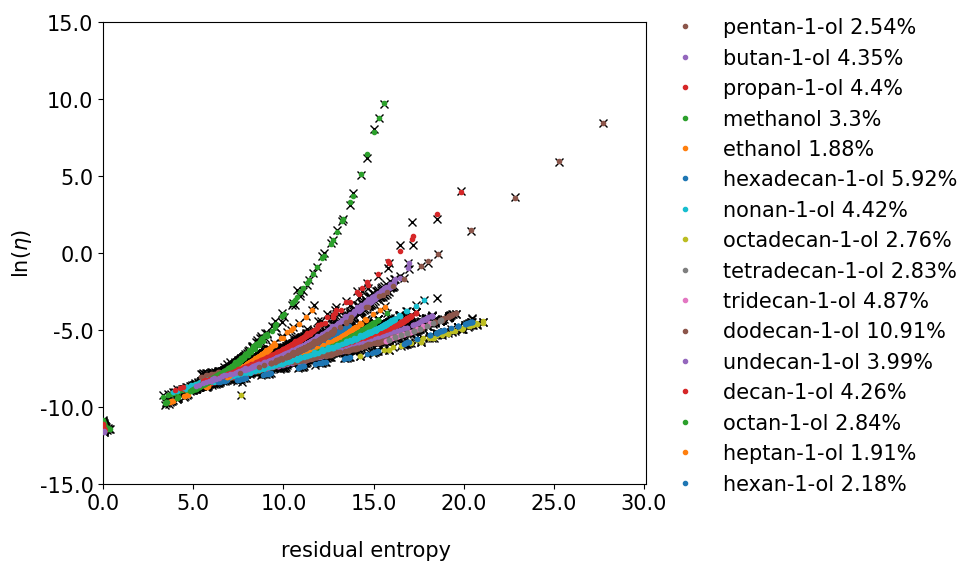

In [6]:
msize=8
fsize=15
alpha=0.3
lsize = 4

with open(config["model_path"]+"best_result_config.json") as f:
    config = json.load(f)

model = load_model0(config)
exp_error = True

data_csv_train = config["data_csv_train"]
data_csv_val = config["data_csv_val"]
data_csv_test = config["data_csv_test"]

y_features = ["log_value"]
# scalerX = joblib.load(config["model_path"]+'Xscaler.gz')
# scalerY = joblib.load(config["model_path"]+'Yscaler.gz')
scalerX = minmax_from_json(config["model_path"]+'Xscaler.json')
scalerY = minmax_from_json(config["model_path"]+'Yscaler.json')
data = dataset(data_csv_train, y_features=y_features,
                     scalerX=scalerX, scalerY=scalerY)


fig, axs = plt.subplots(1, 1, figsize=(7, 6))

axs = [axs]

fig.subplots_adjust(wspace=0.3, hspace=.01)


iii = 0
for ii in range(data.n_species):
    sp = data.get_species_keep(ii).drop_duplicates().iloc[0]
    name = sp["iupac_name"]    
    X, Y = data.get_species(ii)
    if len(Y.shape) > 1 :
            
        # print(Y.shape)
        log_vis = Y[:, 0]
        resd_entropy = X[:, 1].detach().numpy()
        x = scalerX.inverse_transform(X.detach().numpy())[:, 1]

        y_pred0 = torch.squeeze(model.forward_ref(X))
        # print( y_pred0.shape, log_vis.shape )

        log_vis_star = log_vis - y_pred0
        log_vis_star = torch.squeeze(log_vis_star)
        # print( log_vis_star.shape, resd_entropy.shape )

        deg = int(config["n_features"])
        z = np.polyfit(resd_entropy, log_vis_star.detach().numpy(), deg)
        yy = np.poly1d(z)(resd_entropy)
        y_pred = torch.Tensor(yy)
        yy_pred = y_pred + y_pred0
        yy_pred = torch.unsqueeze(yy_pred,1)
        yy_pred = scalerY.inverse_transform(yy_pred.detach().numpy())
        llog_vis = torch.unsqueeze(log_vis,1)
        llog_vis = scalerY.inverse_transform(llog_vis.detach().numpy())

        if exp_error:
            error = np.abs((np.exp(yy_pred) - np.exp(llog_vis)) / np.exp(llog_vis))
            error = np.mean(error)
        else:
            error = np.mean(np.abs((yy_pred - llog_vis) / llog_vis))
        
        #axs[1].plot( x, log_vis_star.detach().numpy(), "kx",zorder=0 )
        #axs[1].plot( x, y_pred, ".",zorder=10, )

        axs[0].plot( x, llog_vis, "kx",zorder=0 )
        axs[0].plot( x, yy_pred, ".",zorder=10, label=name+" "+str(round(error*100,2))+"%") #, label=dd )
        iii += 1

axs[0].set_ylabel(r"ln($\eta$)", fontsize=fsize)
#axs[1].set_ylabel(r"ln($\eta$*)", fontsize=fsize)

txx = np.array(axs[0].get_xticks())
rng = 3 -np.abs(txx[0]-txx[-1])
if txx[0] < 0.5:
    txx[0]=0
if rng > 0:
    txx = np.linspace( np.max([txx[0]-rng/2],0) , txx[-1]+rng/2, 7 )    
else:
    txx = np.linspace( txx[0] , txx[-1], 7 )    
txy = np.array(axs[0].get_yticks())
rng = 3 -np.abs(txy[0]-txy[-1])
if rng > 0:
    txy = np.linspace( txy[0]-rng/2 , txy[-1]+rng/2, 7 )       
else:
    txy = np.linspace( txy[0] , txy[-1], 7 )          
       
txx = np.round(txx,1)
txy = np.round(txy,1)

axs[0].set_xticks(txx,txx,fontsize=fsize)

axs[0].set_yticks(txy,txy,fontsize=fsize)

axs[0].set_xlim([np.max([0,txx[0]]),txx[-1]+0.1])   

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1], frameon=False, fontsize=fsize, bbox_to_anchor=(1, 1.05))

fig.text(0.5, -0.01, "residual entropy", fontsize=fsize, ha='center')     

#plt.legend(bbox_to_anchor=(1, 1.1))
plt.savefig(config["model_path"]+"full_noise.png", bbox_inches="tight")
plt.savefig(config["model_path"]+"full_noise.pdf", bbox_inches="tight")
plt.show()
plt.close()